Finetuning hyperparameters

ROC AUC

Modes: 2 (BN, MC)
Rs: 4 (0,3,6,9)

LRs: 4 (2E-5, 1E-5, 2E-6, 1E-6)
Epochs: 5 (5, 10, 15, 20, #) [mc needs more epochs]

Metrics: 3 (Accuracy+F1, Accuracy+Recall, Recall+F1)
Batch: 2 (16, 32)
Loss: 3 (Default, Custom loss function with weighting, BCE weighted loss)

Confusion matrices

In [51]:
import os, json
cwd = os.getcwd() # should be base directory of repository
import time
import torch
from datasets import DatasetDict, Dataset
output_dir = cwd+"/outputs/fting"
input_dir = cwd+"/inputs/"

In [ ]:
# uncomment if you dont already have the dataset dictionaries generated
'''
from classifier.finetune import load_labelintdcts, create_dsdict
from classifier.run_classifiers import group_duplicates, remove_duplicates, dcno_to_sentlab
with open(input_dir+"/19Jan25_firstdatarev.json","r", encoding="utf-8") as f:
        dcno_json = json.load(f)
with open(input_dir+"/27Jan25_query_checked.json","r", encoding="utf-8") as f:
    qry_json = json.load(f)
sents1, labels1 = dcno_to_sentlab(dcno_json)
sents2, labels2 = dcno_to_sentlab(qry_json)
# merge original and augmented datasets
sents2.extend(sents1)
labels2.extend(labels1)
all_sents, all_labs = remove_duplicates(group_duplicates(sents2,labels2,thresh=90))
int2label_dct, label2int_dct = load_labelintdcts()
sims = [0,3,6,9]
create_dsdict(all_sents, all_labs, label2int_dct, amt=sims, save=True, output_dir=input_dir)
'''

Sanity Check: 965 sentences and 965 labels
Sanity Check: 626 sentences and 626 labels
1419 groups found with a threshold of 90
Sanity check: 1419 sentences and 1419 labels
Sanity Check: 263 incentive sentences and 1156 non-incentive sentences
Incentives: 0.18534178999295278; Non-Incentives: 0.8146582100070472
Sanity Check: 263 incentive sentences and 263 incentive labels

Round 0



Saving the dataset (0/1 shards):   0%|          | 0/851 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/284 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/284 [00:00<?, ? examples/s]

Saved ds_0_bn


Saving the dataset (0/1 shards):   0%|          | 0/157 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/53 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/53 [00:00<?, ? examples/s]

Saved ds_0_mc

Round 3



Saving the dataset (0/1 shards):   0%|          | 0/851 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/284 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/284 [00:00<?, ? examples/s]

Saved ds_3_bn


Saving the dataset (0/1 shards):   0%|          | 0/157 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/53 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/53 [00:00<?, ? examples/s]

Saved ds_3_mc

Round 6



Saving the dataset (0/1 shards):   0%|          | 0/851 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/284 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/284 [00:00<?, ? examples/s]

Saved ds_6_bn


Saving the dataset (0/1 shards):   0%|          | 0/157 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/53 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/53 [00:00<?, ? examples/s]

Saved ds_6_mc

Round 9



Saving the dataset (0/1 shards):   0%|          | 0/851 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/284 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/284 [00:00<?, ? examples/s]

Saved ds_9_bn


Saving the dataset (0/1 shards):   0%|          | 0/157 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/53 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/53 [00:00<?, ? examples/s]

Saved ds_9_mc


First we're going to train our baseline model and get a view of the training progress in a ROC analysis

In [ ]:
'''
from classifier.finetune import finetune_roberta, load_labelintdcts
int2label_dct, label2int_dct = load_labelintdcts()
#sims = [0,3,6,9]
sims = [6]
for e in sims:
    bn_ds = DatasetDict.load_from_disk(f"{output_dir}/../models/ds_{e}_bn")
    mc_ds = DatasetDict.load_from_disk(f"{output_dir}/../models/ds_{e}_mc")
    for model in ["sentence-transformers/paraphrase-xlm-r-multilingual-v1"]:
        torch.cuda.empty_cache()
        finetune_roberta(bn_ds, int2label_dct["bn"], label2int_dct["bn"], "bn", model_name=model, dev='cuda', rstate=e, output_dir=output_dir, lora=False)
        print(f"\nSaved {model} binary model.")
        torch.cuda.empty_cache()
        finetune_roberta(mc_ds, int2label_dct["mc"], label2int_dct["mc"], "mc", model_name=model, dev='cuda', rstate=e, output_dir=output_dir, lora=False)
        print(f"\nSaved {model} multiclass model.")
'''

In [3]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

def plot_roc(labels, probs, mode, rstate, output_dir, int2label):
    if mode=="bn":
        fpr, tpr, thresholds = roc_curve(labels, probs[:, 1])
        roc_auc = auc(fpr, tpr)
        #
        plt.figure()
        plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle='--', color='teal')
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title(f"ROC Curve {mode} {rstate}")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{output_dir}/ROC_{mode}_{rstate}.png")
        #plt.show()
    else:
        n_classes = probs.shape[1]
        y_test_bin = label_binarize(labels, classes=range(n_classes))
        # Compute ROC for each class
        fpr = {}
        tpr = {}
        roc_auc = {}
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        # Plot all
        plt.figure()
        colors = ['firebrick', 'darkorange', 'gold', 'yellowgreen', "deepskyblue", "slateblue"]
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], color=colors[i], label=f"Class {int2label[i]} (AUC = {roc_auc[i]:.2f})")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.title(f"ROC Curve {mode} {rstate}")
        plt.legend()
        plt.grid(True)
        plt.savefig(f"{output_dir}/ROC_{mode}_{rstate}.png")
        #plt.show()

In [76]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer, AdamW, get_linear_schedule_with_warmup
import evaluate
from sklearn.metrics import roc_curve
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils import shuffle
import numpy as np
import torch.nn as nn
from classifier.finetune import finetune_roberta, load_labelintdcts
import gc
'''
class WeightedBNTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):#):#
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Define class weights and loss
        weights = torch.tensor([0.61, 2.70]).to(logits.device)
        loss_fct = nn.CrossEntropyLoss(weight=weights)
        loss = loss_fct(logits, labels)
        # loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss
    
class WeightedMCTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):#):#
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Define class weights and loss
        weights = torch.tensor([1.91, 0.55, 0.60, 5.48, 2.31, 0.72]).to(logits.device)
        loss_fct = nn.CrossEntropyLoss(weight=weights)
        loss = loss_fct(logits, labels)
        # loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss
'''
def finetune_roberta(datasetdct, int2label, label2int, mode, model_name="sentence-transformers/paraphrase-xlm-r-multilingual-v1", dev='cuda', output_dir=f"{os.getcwd()}/outputs/models", hyperparams=False, oversampling=False):
    '''
    '''
    if not hyperparams:
        hyperparams = {
            "epochs":10, 
            "r":9,
            "lr":2e-5,
            "batch_size":16
            }
    epochs = hyperparams["epochs"]
    rstate = hyperparams["r"]
    lr = hyperparams["lr"]
    batch_size = hyperparams["batch_size"]
    start = time.time()
    num_lbs = len(list(int2label))
    print(f'\nLoading model {model_name}\n')
    print("Tokenizing")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    def preprocess_function(examples):
        return tokenizer(examples["text"], truncation=True, padding=True).to(dev)
    #this is definitely inefficient but
    # we tokenize the whole dataset dict
    # even though we only care about training and testing
    tokenized_test = datasetdct["test"].map(preprocess_function, batched=True)
    if not oversampling:
        tokenized_train = datasetdct["train"].map(preprocess_function, batched=True)
    # and if we're oversampling then
    # we only needed the last tokenization for test
    # because we're going to oversample then tokenize this anyways
    else:
        # sampling_strategy='minority'?
        # or fine-tune the RandomOverSampler?
        # https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html
        # shrinkage?
        train_sents = datasetdct["train"]["text"]
        train_labels = datasetdct["train"]["label"]
        ros = RandomOverSampler(sampling_strategy='auto', random_state=rstate)
        train_texts_resampled, train_labels_resampled = ros.fit_resample(np.array(train_sents).reshape(-1, 1), np.array(train_labels))
        train_texts_resampled, train_labels_resampled = shuffle(train_texts_resampled, train_labels_resampled, random_state=rstate)
        flattened_texts = list(train_texts_resampled.flatten())
        conv_dct = {"text":flattened_texts, "label":train_labels_resampled}
        conv_ds = Dataset.from_dict(conv_dct)
        tokenized_train = conv_ds.map(preprocess_function, batched=True)
    accuracy = evaluate.load("accuracy")
    f1 = evaluate.load("f1")
    recall = evaluate.load("recall")
    metric_log = []
    def calc_metrics(pred):
        predictions, labels = pred
        predictions = np.argmax(predictions, axis=1)
        metrics = {
            "accuracy": accuracy.compute(predictions=predictions, references=labels)["accuracy"],
            #"f1": f1.compute(predictions=predictions, references=labels, average="weighted" if mode=="mc" else "binary")["f1"],
            "f1": f1.compute(predictions=predictions, references=labels, average="weighted")["f1"],
            "recall": recall.compute(predictions=predictions, references=labels, average="weighted")["recall"]
        }
        metric_log.append(metrics)
        return metrics
    print("Loading model")
    #
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_lbs,id2label=int2label, label2id=label2int).to(dev)
    training_args = TrainingArguments(
        output_dir=output_dir,
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        seed=9,
        num_train_epochs=epochs,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="best",
        logging_strategy="epoch",
        optim="adamw_torch",
        load_best_model_at_end=True,
        #metric_for_best_model="f1",
        #greater_is_better=True
    )
    '''
    if mode == "bn":
        trainer = WeightedBNTrainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_train,# tokenized_ds["train"],
            eval_dataset=tokenized_test,# tokenized_ds["test"],
            processing_class=tokenizer,
            compute_metrics=calc_metrics,
            #scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_train_steps)
        )
    else:
        trainer = WeightedMCTrainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_train,# tokenized_ds["train"],
            eval_dataset=tokenized_test,# tokenized_ds["test"],
            processing_class=tokenizer,
            compute_metrics=calc_metrics,
        )
    '''
    trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_train,# tokenized_ds["train"],
            eval_dataset=tokenized_test,# tokenized_ds["test"],
            processing_class=tokenizer,
            compute_metrics=calc_metrics,
        )
    
    print("Training")
    trainer.train()
    train_losses = [log["loss"] for log in trainer.state.log_history if "loss" in log]
    eval_losses = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]
    print("Saving")
    trainer.save_model(output_dir+f"/{model_name.split('/')[-1]}_{mode}_e{epochs}_r{rstate}.pt")
    #
    #predictions = trainer.predict(tokenized_ds["holdout"])
    tokenized_ho = datasetdct["holdout"].map(preprocess_function, batched=True)
    predictions = trainer.predict(tokenized_ho)
    # Extract the logits and labels from the predictions object
    logits = predictions.predictions
    labels = predictions.label_ids
    probs = torch.nn.functional.softmax(torch.tensor(logits), dim=1).numpy()
    #
    plot_roc(labels, probs, mode, rstate, output_dir, int2label)
    # Use your compute_metrics function
    metric_log.append({"train_loss":train_losses})
    metric_log.append({"eval_loss": eval_losses})
    metrics = calc_metrics((logits, labels))
    with open(output_dir+f"/{model_name.split('/')[-1]}_{mode}_e{epochs}_r{rstate}.pt/metrics.json", "w", encoding="utf-8") as f:
        json.dump(metric_log, f, ensure_ascii=False, indent=4)
    end = time.time()
    print(metrics)
    print(f"\nSaved {model_name.split('/')[-1]}_{mode}_e{epochs}_r{rstate}.")
    print(f'\nDone in {round((end-start)/60,2)} min')
    return metrics


Here we create all of our finetuned models


Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing


Map:   0%|          | 0/1388 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model
Training


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall
1,0.618600,0.551283,0.728873,0.757769,0.728873
2,0.391800,0.409898,0.781690,0.801751,0.781690
3,0.204200,0.510589,0.767606,0.791443,0.767606
4,0.103900,0.395065,0.841549,0.851524,0.841549
5,0.049200,0.472851,0.841549,0.851524,0.841549
6,0.031400,0.477101,0.859155,0.865170,0.859155
7,0.017300,0.502161,0.859155,0.863668,0.859155
8,0.011200,0.540645,0.859155,0.863668,0.859155
9,0.010000,0.556244,0.862676,0.866685,0.862676
10,0.006600,0.561237,0.859155,0.864439,0.859155


Saving


{'accuracy': 0.8415492957746479, 'f1': 0.8494725547033916, 'recall': 0.8415492957746479}

Saved paraphrase-xlm-r-multilingual-v1_bn_e10_r0.

Done in 11.69 min

Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing


Map:   0%|          | 0/1388 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model
Training


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall
1,0.629100,0.520733,0.820423,0.837836,0.820423
2,0.405400,0.301361,0.880282,0.887577,0.880282
3,0.215000,0.256307,0.876761,0.881051,0.876761
4,0.102400,0.312765,0.876761,0.882923,0.876761
5,0.060300,0.314250,0.901408,0.903999,0.901408
6,0.036300,0.387159,0.890845,0.892706,0.890845
7,0.025200,0.402529,0.883803,0.886508,0.883803
8,0.011900,0.435271,0.887324,0.890285,0.887324
9,0.006700,0.456297,0.883803,0.887195,0.883803
10,0.006700,0.448008,0.883803,0.886508,0.883803


Saving


{'accuracy': 0.8274647887323944, 'f1': 0.8343912551689014, 'recall': 0.8274647887323944}

Saved paraphrase-xlm-r-multilingual-v1_bn_e10_r3.

Done in 12.62 min

Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing


Map:   0%|          | 0/1388 [00:00<?, ? examples/s]

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading model
Training


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall
1,0.615600,0.540599,0.750000,0.775094,0.750000
2,0.390200,0.372374,0.830986,0.840576,0.830986
3,0.203200,0.339425,0.845070,0.850882,0.845070
4,0.099500,0.485536,0.816901,0.831862,0.816901
5,0.051800,0.537136,0.830986,0.840576,0.830986
6,0.027700,0.516092,0.862676,0.866685,0.862676
7,0.016000,0.658865,0.838028,0.847219,0.838028
8,0.013500,0.585867,0.862676,0.865873,0.862676
9,0.012200,0.602512,0.859155,0.862001,0.859155
10,0.007900,0.641944,0.852113,0.857661,0.852113


Saving


{'accuracy': 0.8485915492957746, 'f1': 0.8521165111841916, 'recall': 0.8485915492957746}

Saved paraphrase-xlm-r-multilingual-v1_bn_e10_r6.

Done in 12.21 min

Loading model sentence-transformers/paraphrase-xlm-r-multilingual-v1

Tokenizing


Map:   0%|          | 0/1388 [00:00<?, ? examples/s]

Loading model


Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at sentence-transformers/paraphrase-xlm-r-multilingual-v1 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training


Epoch,Training Loss,Validation Loss,Accuracy,F1,Recall
1,0.618900,0.540722,0.757042,0.782426,0.757042
2,0.394000,0.433644,0.816901,0.833306,0.816901
3,0.210700,0.392971,0.834507,0.848264,0.834507
4,0.102400,0.325032,0.897887,0.901442,0.897887
5,0.052600,0.382991,0.897887,0.901442,0.897887
6,0.028700,0.386598,0.908451,0.909715,0.908451
7,0.017500,0.468134,0.880282,0.886544,0.880282
8,0.013800,0.446688,0.894366,0.897751,0.894366
9,0.013000,0.448570,0.897887,0.900265,0.897887
10,0.009600,0.462094,0.890845,0.894032,0.890845


Saving


{'accuracy': 0.823943661971831, 'f1': 0.8314627347417841, 'recall': 0.823943661971831}

Saved paraphrase-xlm-r-multilingual-v1_bn_e10_r9.

Done in 13.69 min
{'bn_0': {'accuracy': 0.8415492957746479, 'f1': 0.8494725547033916, 'recall': 0.8415492957746479}, 'bn_3': {'accuracy': 0.8274647887323944, 'f1': 0.8343912551689014, 'recall': 0.8274647887323944}, 'bn_6': {'accuracy': 0.8485915492957746, 'f1': 0.8521165111841916, 'recall': 0.8485915492957746}, 'bn_9': {'accuracy': 0.823943661971831, 'f1': 0.8314627347417841, 'recall': 0.823943661971831}}


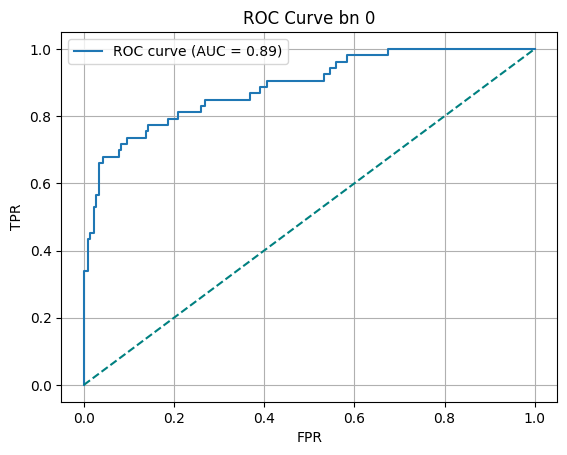

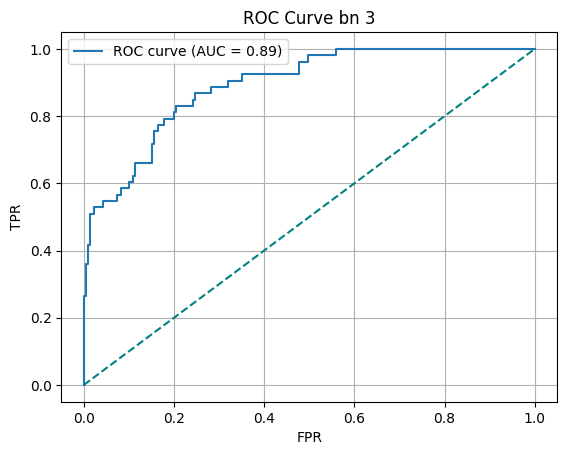

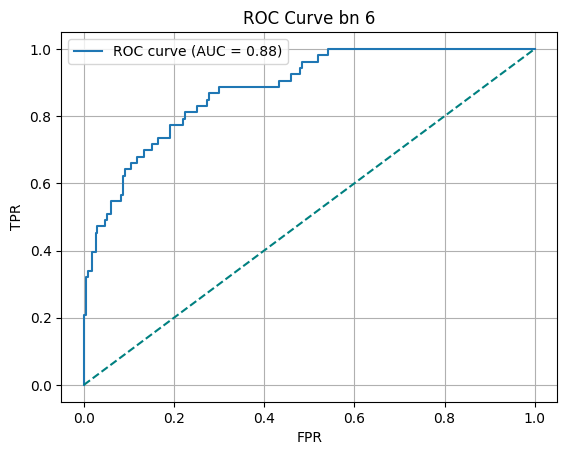

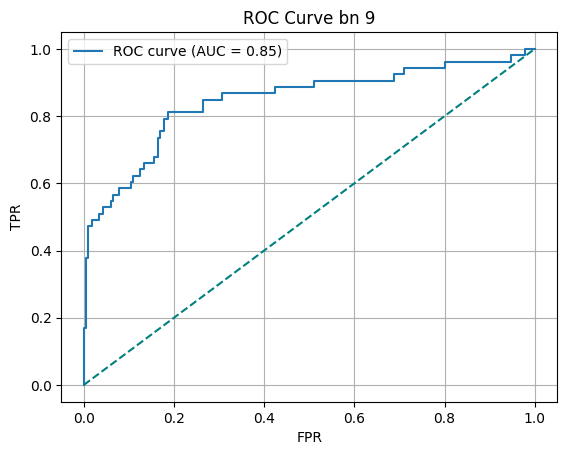

In [77]:
int2label_dct, label2int_dct = load_labelintdcts()
metriclog = {}
exps = [0,3,6,9]#[6]#
ovs = True
torch.cuda.empty_cache()
gc.collect()
for r in exps:
    bn_ds = DatasetDict.load_from_disk(f"{input_dir}/ds_{r}_bn")
    mc_ds = DatasetDict.load_from_disk(f"{input_dir}/ds_{r}_mc")
    hyper = {
        "epochs":10, 
        "r":r, 
        "lr":5E-6,
        "batch_size":16
        }
    torch.cuda.empty_cache()
    gc.collect()
    metrics = finetune_roberta(bn_ds, int2label_dct["bn"], label2int_dct["bn"], "bn", model_name="sentence-transformers/paraphrase-xlm-r-multilingual-v1", dev='cuda', output_dir=output_dir, hyperparams=hyper, oversampling=ovs)
    metriclog[f'bn_{r}'] = metrics
    '''
    hyper = {
        "epochs":15, 
        "r":r, 
        "lr":2E-5,
        "batch_size":16
        }
    torch.cuda.empty_cache()
    gc.collect()
    metrics = finetune_roberta(mc_ds, int2label_dct["mc"], label2int_dct["mc"], "mc", model_name="sentence-transformers/paraphrase-xlm-r-multilingual-v1", dev='cuda', output_dir=output_dir, hyperparams=hyper, oversampling=ovs)
    metriclog[f'mc_{r}'] = metrics
    '''
print(metriclog)

Then test the model by using it to predict labels, or by using it as an embedder with an external classifier that predicts labels

In [78]:
from classifier.ft_classification import run_experiments, modelpred_dsdct_clsf, svm_dsdct_clsf
from classifier.run_classifiers import res_dct_to_cls_rpt, cls_rpt_to_exp_rpt
from classifier.finetune import load_labelintdcts
from tqdm import tqdm
int2label_dct, label2int_dct = load_labelintdcts()
outfn = "11Apr25_0"

models = {}
for i in exps:#[0,3,6,9]:#range(10):
    #models[f'bert_bn_e5_r{i}'] = output_dir+f'/paraphrase-xlm-r-multilingual-v1_bn_e5_r{i}.pt'
    models[f'bert_bn_e10_r{i}'] = output_dir+f'/paraphrase-xlm-r-multilingual-v1_bn_e10_r{i}.pt'
    #models[f'bert_mc_e15_r{i}'] = output_dir+f'/paraphrase-xlm-r-multilingual-v1_mc_e15_r{i}.pt'
print(list(models))
model_res_dict = {'bn':{}, 'mc':{}}
svm_res_dict = {'bn':{}, 'mc':{}}
stw = time.time()
for model in tqdm(models):
    print(f'\nRunning model {model}')
    #print(torch.cuda.memory_allocated() / 1e9, "GB allocated before model")
    #print(torch.cuda.memory_reserved() / 1e9, "GB reserved before model")
    st = time.time()
    mode = model.split('_')[1]
    torch.cuda.empty_cache()
    if mode=='bn':
        r = model.split('_')[-1][1:]
        if r == "h":
            r = model.split('_')[-2][1:]
        try:
            dsdct = DatasetDict.load_from_disk(input_dir+f"/ds_{r}_bn")
            model_res_dict[mode][model] = modelpred_dsdct_clsf(dsdct, int2label_dct[mode], label2int_dct[mode], models[model], cuda=True)
            svm_res_dict[mode][model] = svm_dsdct_clsf(dsdct, models[model], cuda=True)
        except Exception as e:
            print(f"\nError in {model}: {e}\n")
    else:
        r = model.split('_')[-1][1:]
        try:
            dsdct = DatasetDict.load_from_disk(input_dir+f"/ds_{r}_mc")
            model_res_dict[mode][model] = modelpred_dsdct_clsf(dsdct, int2label_dct[mode], label2int_dct[mode], models[model], cuda=True)
            svm_res_dict[mode][model] = svm_dsdct_clsf(dsdct, models[model], cuda=True)
        except Exception as e:
            print(f"\nError in {model}: {e}\n")
    print(f"{model} run completed in in {round(time.time()-st,2)}s")
    torch.cuda.empty_cache()
    #gc.collect()
etw = time.time()-stw
print("Time elapsed total:", etw//60, "min and", round(etw%60), "sec")

['bert_bn_e10_r0', 'bert_bn_e10_r3', 'bert_bn_e10_r6', 'bert_bn_e10_r9']


  0%|          | 0/4 [00:00<?, ?it/s]


Running model bert_bn_e10_r0
Loading tokenizer
Loading model
Running model


100%|██████████| 9/9 [00:04<00:00,  1.94it/s]


Freeing memory


No sentence-transformers model found with name c:\Users\allie\Documents\GitHub\policy-classifier/outputs/fting/paraphrase-xlm-r-multilingual-v1_bn_e10_r0.pt. Creating a new one with mean pooling.
Some weights of XLMRobertaModel were not initialized from the model checkpoint at c:\Users\allie\Documents\GitHub\policy-classifier/outputs/fting/paraphrase-xlm-r-multilingual-v1_bn_e10_r0.pt and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1135/1135 [00:15<00:00, 71.53it/s]


Encoding test sentences.


 25%|██▌       | 1/4 [00:28<01:26, 28.89s/it]

bert_bn_e10_r0 run completed in in 28.89s

Running model bert_bn_e10_r3
Loading tokenizer
Loading model
Running model


100%|██████████| 9/9 [00:04<00:00,  2.00it/s]


Freeing memory


No sentence-transformers model found with name c:\Users\allie\Documents\GitHub\policy-classifier/outputs/fting/paraphrase-xlm-r-multilingual-v1_bn_e10_r3.pt. Creating a new one with mean pooling.
Some weights of XLMRobertaModel were not initialized from the model checkpoint at c:\Users\allie\Documents\GitHub\policy-classifier/outputs/fting/paraphrase-xlm-r-multilingual-v1_bn_e10_r3.pt and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1135/1135 [00:15<00:00, 72.20it/s]


Encoding test sentences.


 50%|█████     | 2/4 [00:57<00:57, 28.82s/it]

bert_bn_e10_r3 run completed in in 28.75s

Running model bert_bn_e10_r6
Loading tokenizer
Loading model
Running model


100%|██████████| 9/9 [00:04<00:00,  1.95it/s]


Freeing memory


No sentence-transformers model found with name c:\Users\allie\Documents\GitHub\policy-classifier/outputs/fting/paraphrase-xlm-r-multilingual-v1_bn_e10_r6.pt. Creating a new one with mean pooling.
Some weights of XLMRobertaModel were not initialized from the model checkpoint at c:\Users\allie\Documents\GitHub\policy-classifier/outputs/fting/paraphrase-xlm-r-multilingual-v1_bn_e10_r6.pt and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1135/1135 [00:16<00:00, 68.43it/s]


Encoding test sentences.


 75%|███████▌  | 3/4 [01:27<00:29, 29.33s/it]

bert_bn_e10_r6 run completed in in 29.92s

Running model bert_bn_e10_r9
Loading tokenizer
Loading model
Running model


100%|██████████| 9/9 [00:04<00:00,  2.01it/s]


Freeing memory


No sentence-transformers model found with name c:\Users\allie\Documents\GitHub\policy-classifier/outputs/fting/paraphrase-xlm-r-multilingual-v1_bn_e10_r9.pt. Creating a new one with mean pooling.
Some weights of XLMRobertaModel were not initialized from the model checkpoint at c:\Users\allie\Documents\GitHub\policy-classifier/outputs/fting/paraphrase-xlm-r-multilingual-v1_bn_e10_r9.pt and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 1135/1135 [00:16<00:00, 68.33it/s]


Encoding test sentences.


100%|██████████| 4/4 [01:56<00:00, 29.11s/it]

bert_bn_e10_r9 run completed in in 28.86s
Time elapsed total: 1.0 min and 56 sec


In [79]:
with open(f"{output_dir}/randp_{outfn}_model.json", 'w', encoding="utf-8") as outfile:
    json.dump(model_res_dict, outfile, ensure_ascii=False, indent=4)
with open(f"{output_dir}/randp_{outfn}_svm.json", 'w', encoding="utf-8") as outfile:
    json.dump(svm_res_dict, outfile, ensure_ascii=False, indent=4)
mdl_cls_rpt = res_dct_to_cls_rpt(model_res_dict, int2label_dct)
mdl_exp_rpt = cls_rpt_to_exp_rpt(mdl_cls_rpt)
with open(f"{output_dir}/exprpt_{outfn}_mdl.json", 'w', encoding="utf-8") as outfile:
    json.dump(mdl_exp_rpt, outfile, ensure_ascii=False, indent=4)
svm_cls_rpt = res_dct_to_cls_rpt(svm_res_dict, int2label_dct)
svm_exp_rpt = cls_rpt_to_exp_rpt(svm_cls_rpt)
with open(f"{output_dir}/exprpt_{outfn}_svm.json", 'w', encoding="utf-8") as outfile:
    json.dump(svm_exp_rpt, outfile, ensure_ascii=False, indent=4)

print(f"finished {outfn}")

finished 11Apr25_0
